<a href="https://colab.research.google.com/github/dbeniteze/autoencoder_convolucional/blob/master/conv_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install keras==2.3.1

%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

TensorFlow 2.x selected.
Found GPU at: /device:GPU:0


In [0]:
# Larger CNN for the MNIST Dataset
from keras import backend as K
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import LeakyReLU
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
from matplotlib import pyplot as plt
import numpy as np
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# reshape to be [samples][width][height][channels]
X_train = X_train.reshape((X_train.shape[0], 28, 28, 1)).astype('float32')
X_test = X_test.reshape((X_test.shape[0], 28, 28, 1)).astype('float32')
# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255


In [0]:
# autoencoder simple con upsampling
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
LF = (5,5)
x = Conv2D(16, LF, activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, LF, activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, LF, activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional

x = Conv2D(8, (3,3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3,3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3,3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

In [71]:
#autoencoder con Conv2DTranspose
input_img = Input(shape=(28, 28, 1))  # adapt this if using `channels_first` image data format
LF = (5,5)
x = Conv2D(32, kernel_size=LF, activation='relu')(input_img)
x = Conv2D(16, kernel_size=LF, activation='relu')(x)
encoded = Conv2D(8, kernel_size=LF, activation='relu')(x)

x = Conv2DTranspose(8, kernel_size=LF, activation='relu')(encoded)
x = Conv2DTranspose(16, kernel_size=LF, activation='relu')(x)
x = Conv2DTranspose(32, kernel_size=LF, activation='relu')(x)
decoded = Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.summary()

Model: "model_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_106 (Conv2D)          (None, 24, 24, 32)        832       
_________________________________________________________________
conv2d_107 (Conv2D)          (None, 20, 20, 16)        12816     
_________________________________________________________________
conv2d_108 (Conv2D)          (None, 16, 16, 8)         3208      
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 20, 20, 8)         1608      
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 24, 24, 16)        3216      
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 28, 28, 32)        128

In [73]:
def coeff_determination(y_true, y_pred):
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

autoencoder.compile(optimizer='adadelta',  loss='mean_squared_error', metrics=[coeff_determination])

autoencoder.fit(X_train, X_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test, X_test))


Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 8s 130us/step - loss: 0.0281 - coeff_determination: 0.7044 - val_loss: 0.0074 - val_coeff_determination: 0.9220
Epoch 2/50
60000/60000 [==============================] - 7s 119us/step - loss: 0.0060 - coeff_determination: 0.9366 - val_loss: 0.0045 - val_coeff_determination: 0.9522
Epoch 3/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.0041 - coeff_determination: 0.9565 - val_loss: 0.0048 - val_coeff_determination: 0.9499
Epoch 4/50
60000/60000 [==============================] - 7s 121us/step - loss: 0.0032 - coeff_determination: 0.9665 - val_loss: 0.0025 - val_coeff_determination: 0.9734
Epoch 5/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.0026 - coeff_determination: 0.9723 - val_loss: 0.0024 - val_coeff_determination: 0.9745
Epoch 6/50
60000/60000 [==============================] - 7s 120us/step - loss: 0.0023 - coeff_deter

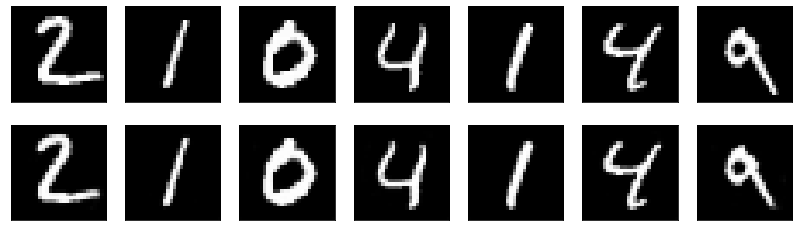

In [74]:
#visualizacion de la decodificacion
decoded_imgs = autoencoder.predict(X_test)

n = 7
plt.figure(figsize=(14, 4))
for i in range(n):
    i = i + 1
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(X_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()